In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import (KMeans, DBSCAN)
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pd.set_option('display.max_rows', 500)

**Задача**:
1. Разделить активную базу на кластеры и описать их

**Что хочу исследовать**:
1. Разные алгоритмы кластеризации
2. Разные способы векторизации
3. Разные метрики эффективности кластеризации
4. PCA и t-SNE: методики снижения размерности исходных данных

### Препроцессим данные

In [217]:
df = pd.read_csv('../resources/test.csv').drop_duplicates()
df.head()

,event_timestamp,current_path,next_path,user_id,browser,os,session,mapped_event,utm_source,utm_medium
0,2020-07-07 14:55:07,/catalog/phone/225/apple/iphone-6s-plus/6s-plu...,NaN,000019de-e3c2-4af0-8e0c-979b0d5b63cd,Chrome,Windows,0.0,session_start,NaN,NaN
1,2020-07-07 14:55:08,/catalog/phone/225/apple/iphone-6s-plus/6s-plu...,NaN,000019de-e3c2-4af0-8e0c-979b0d5b63cd,Chrome,Windows,0.0,catalog_page,NaN,NaN
2,2020-07-07 14:55:09,/catalog/phone/225/apple/iphone-6s-plus/6s-plu...,NaN,000019de-e3c2-4af0-8e0c-979b0d5b63cd,Chrome,Windows,0.0,lost,NaN,NaN
3,2020-06-20 17:13:51,/catalog/other/10691/5391503,NaN,00009a1c-69ad-4bbf-81e0-75dad05075b5,Mobile Safari,iOS,1.0,session_start,NaN,NaN
4,2020-06-20 17:13:52,/catalog/other/10691/5391503,NaN,00009a1c-69ad-4bbf-81e0-75dad05075b5,Mobile Safari,iOS,1.0,OpenProductPage,NaN,NaN


In [218]:
df['session'] = df['session'].combine_first(df.groupby('user_id').session.shift(1))
df['session'] = df['session'].combine_first(df.groupby('user_id').session.shift(1))

### Выберем события, по которым будем делать эмбеддинг

In [226]:
ts_df = df[['event_timestamp', 'user_id', 'session', 'mapped_event']].drop_duplicates()

In [227]:
events_df = \
ts_df.groupby('mapped_event').\
agg({'session':'count'}).\
reset_index().\
sort_values(by='session', ascending=False)

events_df['%'] = events_df['session'].cumsum() / events_df['session'].sum()

оценим частотность событий

<BarContainer object of 72 artists>

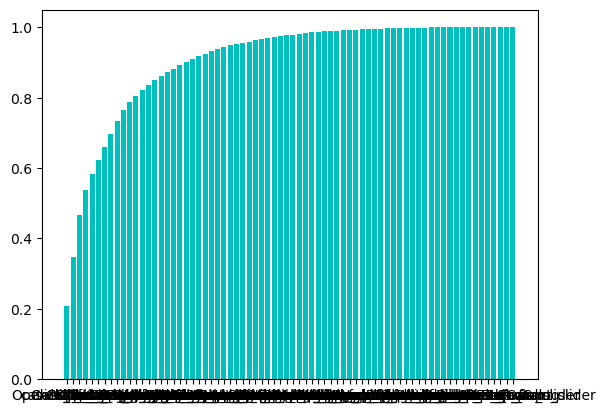

In [228]:
plt.bar(data=events_df, x=events_df['mapped_event'], height=events_df['%'], color='c')

In [231]:
events_df.head(30)

,mapped_event,session,%
36,catalog_page,791559,0.209071
18,OpenProductPage,523200,0.347262
67,session_start,448626,0.465755
49,lost,267575,0.536429
66,session_end,173341,0.582212
5,Click_Catalog_Filter,150223,0.621890
50,main_page,142028,0.659403
8,Click_Catalog_Tags,141674,0.696823
17,List_Slider,136849,0.732968
28,Open_ProductSpecs,118969,0.764391


Возьмем самые частые события + те, которые являются важными с т.з. бизнеса - конвертации/ивенты в корзине

In [232]:
# события, которые считаем главными и которые хотим кластеризовать
events_to_cluster = ['catalog_page'
 , 'OpenProductPage'
 , 'session_start'
 , 'lost'
 , 'session_end'
 , 'Click_Catalog_Filter'
 , 'main_page'
 , 'cart_page'
 , 'search_result_page'
 , 'AddTo_Cart'
 , 'GoTo_Cart'
 , 'pass']

In [233]:
ts_df = ts_df[ts_df['mapped_event'].isin(events_to_cluster)]

In [234]:
ts_df.head()

,event_timestamp,user_id,session,mapped_event
0,2020-07-07 14:55:07,000019de-e3c2-4af0-8e0c-979b0d5b63cd,0.0,session_start
1,2020-07-07 14:55:08,000019de-e3c2-4af0-8e0c-979b0d5b63cd,0.0,catalog_page
2,2020-07-07 14:55:09,000019de-e3c2-4af0-8e0c-979b0d5b63cd,0.0,lost
3,2020-06-20 17:13:51,00009a1c-69ad-4bbf-81e0-75dad05075b5,1.0,session_start
4,2020-06-20 17:13:52,00009a1c-69ad-4bbf-81e0-75dad05075b5,1.0,OpenProductPage


### Vectorizing

In [242]:
# схлопываем все ивенты в последовательность
chains_df = ts_df.groupby('user_id').\
agg({'mapped_event': lambda x: ','.join(x), 'session':'nunique'}).\
reset_index()

chains_df.head()

,user_id,mapped_event,session
0,000019de-e3c2-4af0-8e0c-979b0d5b63cd,"session_start,catalog_page,lost",1
1,00009a1c-69ad-4bbf-81e0-75dad05075b5,"session_start,OpenProductPage,lost",1
2,0000ccf4-7a6d-4ec2-837c-0e7c01d92b04,"session_start,catalog_page,session_end,session...",3
3,00010aae-fcc8-457a-847b-3fb5b9867243,"session_start,catalog_page,lost",1
4,0001692d-845f-4256-8ca9-2987060dbf1c,"session_start,main_page,catalog_page,OpenProdu...",1


#### CountVectorizing

In [264]:
cv = CountVectorizer(analyzer='word', ngram_range=(1,3))
cv.fit(raw_documents=chains_df['mapped_event'])
emb_cols = cv.get_feature_names()

chains_df[emb_cols]=cv.transform(raw_documents=chains_df['mapped_event']).toarray()

In [165]:
#TODO: как-то заложить, что это разные сессии (или это учтено на уровне Count'а?)

Признаков слишком много - попробуем сократить пространство и перейти в другой базис

##### PCA

In [271]:
dimred = PCA(n_components=10).fit(chains_df[emb_cols])

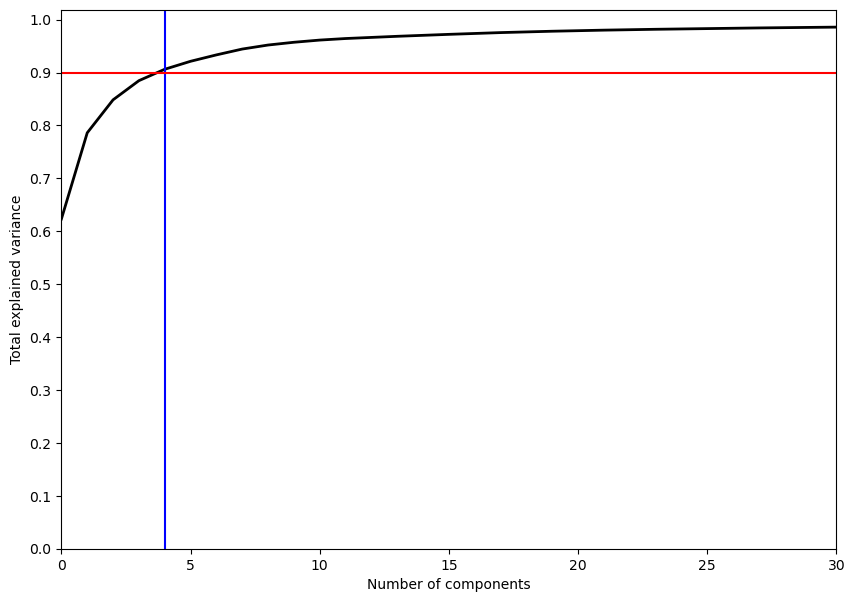

In [282]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(dimred.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 30)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(4, c='b')
plt.axhline(0.9, c='r')
plt.show();

Оптимальная размерность - 4. Покрывает 90+% дисперсии